# Lab Assignment 3

### Marleen Rijksen (10465030)

In [1]:
# import parser file to get .tsp data
import parser_final

# necessary packages

import ast

import sys
import csv
csv.field_size_limit(sys.maxsize)
import random
import numpy as np
%pylab inline
pylab.rcParams['figure.figsize'] = [10, 6]

Populating the interactive namespace from numpy and matplotlib


/home/marleen/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# load data
#city_list = parser_final.produce_final('a280.tsp.txt')
file = "eil51.tsp.txt"
data = parser_final.read_tsp_data(file)
dimension = parser_final.detect_dimension(data)
city_list = parser_final.get_cities(data,dimension)

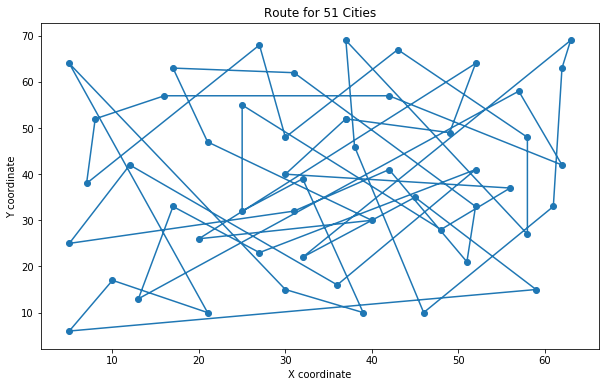

In [7]:
plot_route(city_list)

In [4]:
# function to create distance matrix
def dist_matrix(city_list):
    matrix = np.zeros([len(city_list), len(city_list)], dtype=int)
    
    # iterate over all possible distances
    for i in range(len(city_list)):
        for j in range(len(city_list)):
            distance = int(round(np.sqrt((city_list[i][1][0] - city_list[j][1][0]) ** 2 + \
                           (city_list[i][1][1] - city_list[j][1][1]) ** 2)))
            matrix[i][j] = distance
    return matrix

In [5]:
def distance2(indice_list, city_list, distance_matrix):
    total_distance = 0
    
    # iterate over all cities
    for i in range(len(indice_list) - 1):
        
        # define start and end city
        start = indice_list[i]
        end = indice_list[i + 1]
        
        # add distance between cities
        total_distance += distance_matrix[start - 1][end - 1]
    
    # add final distance
    total_distance += distance_matrix[indice_list[-1] - 1][indice_list[0] - 1]
    return total_distance
        

In [6]:
# function to plot route between cities
def plot_route(city_list):
    
    # get x and y coordinates of visited cities
    x_coordinates = [tup[1][0] for tup in city_list]
    y_coordinates = [tup[1][1] for tup in city_list]
    
    # finish route
    x_coordinates.append(x_coordinates[0])
    y_coordinates.append(y_coordinates[0])
    
    # plot city and line between them 
    plt.plot(x_coordinates, y_coordinates)
    plt.scatter(x_coordinates, y_coordinates)
    plt.title('Route for 51 Cities')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.show()

In [8]:
# function for two opt with indices
def two_opt2(indice_list):
    
    # take two random numbers
    i = np.random.randint(0, len(indice_list))
    j = np.random.randint(0, len(indice_list))
    
    # smallest number is first index
    x = min(i, j)
    y = max(i, j)
    
    # switch route between city indices
    new_route = [city for city in indice_list[0:x]]
    new_route.extend(list(reversed([city for city in indice_list[x:y + 1]])))
    new_route.extend([city for city in indice_list[y + 1:]])
    return new_route    

# function for city replacement algorithm
def replace(indice_list):
    
    # take two random numbers
    i = np.random.randint(0, len(indice_list))
    j = np.random.randint(0, len(indice_list))
    
    # choose city to switch
    indice = indice_list[i]
    
    # remove from list
    indice_list.remove(indice)
    
    # insert list in new position
    indice_list.insert(j, indice)
    
    return indice_list    

In [9]:
# function to check file for integers
def RepresentsInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

In [10]:
# function to find route based on indices
def find_route(indice_list, city_list):
    opt_route = []
    for i in indice_list:
        opt_route.append(tuple(city_list[i - 1]))
    return opt_route   

In [11]:
# function to do the simulated annealing with indices
def sim_annealing2(indice_list, city_list, dist_matrix, chain_length, T, T_min, num_steps, lin):
    
    # list to keep track of distance
    dist_list = []
    
    # create random solution
    np.random.shuffle(indice_list)
    
    # compute length of this tour
    dist = distance2(indice_list, city_list, dist_matrix)
    
    # cumulative acceptance rate
    cm_accep_list = []
    accept = 0
    count = 0
    
    # constants
    T_0 = T
    smallest_dist = 500000
    alpha = (T_min / T_0) ** (1 / num_steps)
    
    # decide when to plot
    plotting_T = [20, 15, 10, 9, 8, 7, 6.5, 6, 5.5, 5, 4.5, 4, 3.5, 3, 2.5, 2, 1, 0.75, 0.5, 0.25, 0.2, 0.15, 0.10, 0.05, 0]
    j = 0
    
    # plot starting solution
#     print(plotting_T[0], distance2(indice_list, city_list, dist_matrix))
#     plot_route(find_route(indice_list, city_list))
    
    # keep iterating
    while T > T_min:
        
        # iterate over Markov Chain
        for i in range(chain_length):
            count += 1
            dist_list.append(dist)
        
            # generate new solution with two opt
            new_indice_list = indice_list.copy()
            new_indice_list = two_opt2(new_indice_list)
#             new_indice_list = replace(new_indice_list)
            
            # compute new distance
            new_dist = distance2(new_indice_list, city_list, dist_matrix)
            
            # search for overall minimum
            if new_dist < smallest_dist:
                smallest_dist = new_dist
                best_indice_list = new_indice_list.copy()
                
            # compute acceptance probability
            p = min(1, np.exp((dist - new_dist) / T))

            # determine to accept new state or not
            rn = np.random.uniform()
            if rn < p:
                dist = new_dist
                indice_list = new_indice_list
                accept += 1
                
            cm_accep_list.append(accept / count)
            
#         # plot for certain temperatures
#         if T <= plotting_T[j]:
#             print(plotting_T[j], distance2(indice_list, city_list, dist_matrix))
#             plot_route(find_route(indice_list, city_list))
#             j += 1
        
        # lower temperature with linear scheme
        if lin == False:
            T *= alpha
            
        # exponential scheme
        elif lin == True:
            T -= (T_0 - T_min) / num_steps
    return best_indice_list, smallest_dist, dist_list, cm_accep_list

## Try out different cooling down schedules and starting temperatures for 51 cities

In [197]:
# create indice list and distance matrix
indice_list = [tup[0] for tup in city_list]
d_m = dist_matrix(city_list)
                  
# store all dist lists
all_indice_list = []
all_smallest_dist = []
all_dist_list = []
all_cm_accep_list = []

# do multiple simulations for each temperature
for i in range(50):

    # execute simulated annealing
    chain_length = 1
    T_start = 
    T_min = 0.01
    num_steps = 1e5
    indice_list, smallest_dist, dist_list, cm_accep_list = sim_annealing2(indice_list, city_list, d_m, chain_length, \
                                                                          T_start, T_min, num_steps, True)
    # store all data
    all_indice_list.append(indice_list)
    all_dist_list.append(dist_list)
    all_smallest_dist.append(smallest_dist)
    all_cm_accep_list.append(cm_accep_list)

# write all data to csv files
with open('51_2exp_all_indices.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(all_indice_list)
myfile.close()
with open('51_2exp_all_dist.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(all_dist_list)
myfile.close()
with open('51_2exp_all_cm_accep_list.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(all_cm_accep_list)
myfile.close()
with open('51_2exp_smallest_dist.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(all_smallest_dist)
myfile.close()

## Investigate Data

In [58]:
csvlist = []
distlist = []
cmlist = []
T_start = 2

# open data and store in lists
with open('51_{}exp_all_dist.csv'.format(T_start), 'r') as myfile:
    wr = csv.reader(myfile, quoting=csv.QUOTE_ALL)
    for row in wr:
        for li in row:
            distlist.append(ast.literal_eval(li))
with open('51_{}exp_all_cm_accep_list.csv'.format(T_start), 'r') as myfile:
    wr = csv.reader(myfile, quoting=csv.QUOTE_ALL)
    for row in wr:
        for li in row:
            cmlist.append(ast.literal_eval(li))

Final (Mean) Distance 441.24


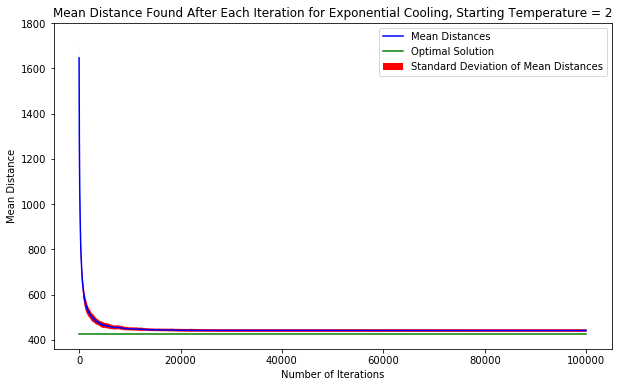

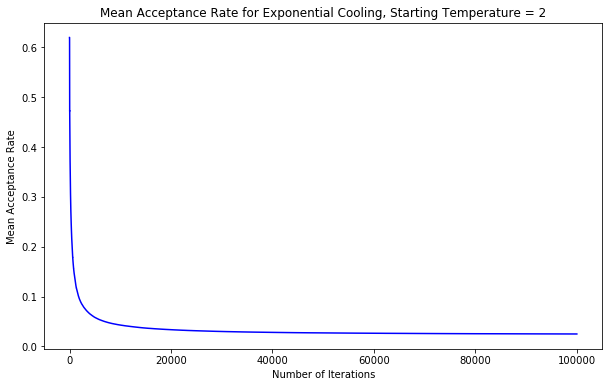

In [59]:
# find means and stds
mean_distances = np.array(mean(distlist, 0))
std_distances = np.array(std(distlist, 0))
mean_cm_accep_rates = np.array(mean(cmlist, 0))
std_cm_rates = np.array(std(cmlist, 0))
num_steps = len(mean_distances)

# plot mean distances
plt.figure(1)
plt.plot(mean_distances, 'b', label='Mean Distances')
# fill_between(range(num_steps), mean_distances - std_distances, mean_distances + std_distances,
#         alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
fill_between(range(num_steps), mean_distances - std_distances, mean_distances + std_distances,
         facecolor='r', label='Standard Deviation of Mean Distances')
plt.xlabel('Number of Iterations')
plt.ylabel('Mean Distance')
plt.title('Mean Distance Found After Each Iteration for Exponential Cooling, Starting Temperature = {}'.format(T_start))
plt.plot([0, 100000], [426, 426], 'g', label='Optimal Solution')
plt.legend()
plt.savefig('51_{}_exp_mean_distance.pdf'.format(T_start), format='pdf')

# plot mean acceptance rate
plt.figure(2)
plt.plot(mean_cm_accep_rates, 'b')
plt.title('Mean Acceptance Rate for Exponential Cooling, Starting Temperature = {}'.format(T_start))
plt.xlabel('Number of Iterations')
plt.ylabel('Mean Acceptance Rate')
plt.savefig('51_{}_exp_mean_cm_rates.pdf'.format(T_start), format='pdf')

# print final convergence value
print('Final (Mean) Distance', mean_distances[-1])



## Try out different cooling down schedules and starting temperatures for 281 cities

In [105]:
file = "a280.tsp.txt"
data = parser_final.read_tsp_data(file)
dimension = parser_final.detect_dimension(data)
city_list = parser_final.get_cities(data,dimension)

# create indice list and distance matrix
indice_list = [tup[0] for tup in city_list]
d_m = dist_matrix(city_list)
                  
# store all dist lists
all_indice_list = []
all_smallest_dist = []
all_dist_list = []
all_cm_accep_list = []

# do multiple simulations for each temperature
for i in range(50):

    # execute simulated annealing
    chain_length = 1
    T_start = 20
    T_min = 0.01
    num_steps = 1e6
    indice_list, smallest_dist, dist_list, cm_accep_list = sim_annealing2(indice_list, city_list, d_m, chain_length, \
                                                                          T_start, T_min, num_steps, False)
    # store all data
    all_indice_list.append(indice_list)
    all_dist_list.append(dist_list)
    all_smallest_dist.append(smallest_dist)
    all_cm_accep_list.append(cm_accep_list)

# write all data to csv files
with open('281_20Fexp_all_indices.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(all_indice_list)
myfile.close()
with open('281_20Fexp_all_dist.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(all_dist_list)
myfile.close()
with open('281_20Fexp_all_cm_accep_list.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(all_cm_accep_list)
myfile.close()
with open('281_20Fexp_smallest_dist.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(all_smallest_dist)
myfile.close()



## Investigate Data

In [137]:
csvlist = []
distlist = []
cmlist = []
T_start = 50

# open data and store in lists
with open('51_{}exp_all_dist.csv'.format(T_start), 'r') as myfile:
    wr = csv.reader(myfile, quoting=csv.QUOTE_ALL)
    for row in wr:
        for li in row:
            distlist.append(ast.literal_eval(li))
with open('51_{}exp_all_cm_accep_list.csv'.format(T_start), 'r') as myfile:
    wr = csv.reader(myfile, quoting=csv.QUOTE_ALL)
    for row in wr:
        for li in row:
            cmlist.append(ast.literal_eval(li))

50
Final (Mean) Distance 440.34
95% Confidence Interval 1.39654366949


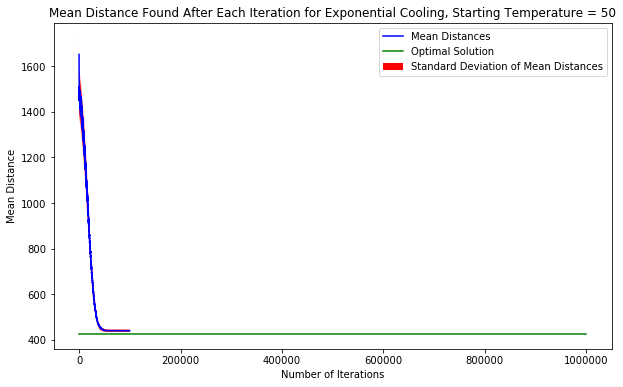

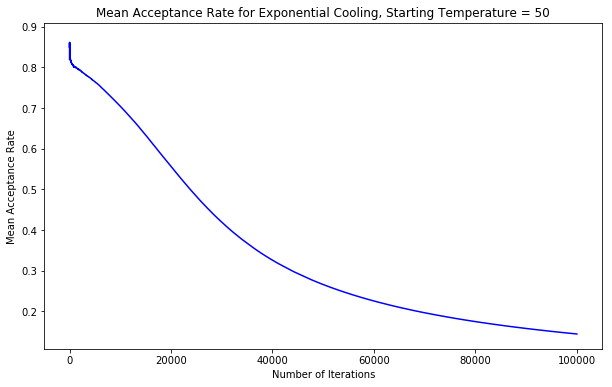

In [138]:
# find means and stds
mean_distances = np.array(mean(distlist, 0))
std_distances = np.array(std(distlist, 0))
mean_cm_accep_rates = np.array(mean(cmlist, 0))
std_cm_rates = np.array(std(cmlist, 0))
num_steps = len(mean_distances)

# plot mean distances
plt.figure(1)
plt.plot(mean_distances, 'b', label='Mean Distances')
# fill_between(range(num_steps), mean_distances - std_distances, mean_distances + std_distances,
#         alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
fill_between(range(num_steps), mean_distances - std_distances, mean_distances + std_distances,
         facecolor='r', label='Standard Deviation of Mean Distances')
plt.xlabel('Number of Iterations')
plt.ylabel('Mean Distance')
plt.title('Mean Distance Found After Each Iteration for Exponential Cooling, Starting Temperature = {}'.format(T_start))
plt.plot([0, 1000000], [426, 426], 'g', label='Optimal Solution')
plt.legend()
plt.savefig('51_{}_exp_mean_distance.pdf'.format(T_start), format='pdf')

# plot mean acceptance rate
plt.figure(2)
plt.plot(mean_cm_accep_rates, 'b')
plt.title('Mean Acceptance Rate for Exponential Cooling, Starting Temperature = {}'.format(T_start))
plt.xlabel('Number of Iterations')
plt.ylabel('Mean Acceptance Rate')
plt.savefig('51_{}_exp_mean_cm_rates.pdf'.format(T_start), format='pdf')

# print final convergence value
print(len(distlist))
print('Final (Mean) Distance', mean_distances[-1])
print('95% Confidence Interval', 1.96 * std_distances[-1] / np.sqrt(len(distlist)))



In [108]:
# find minimum of all simulations
minimum = 999999999
for li in distlist:
    new_minimum = min(li)
    if new_minimum < minimum:
        minimum = new_minimum
print("Absolute minimum:", minimum)

Absolute minimum: 2690


## Visualization of Optimal Solution

Optimal distance: 2579


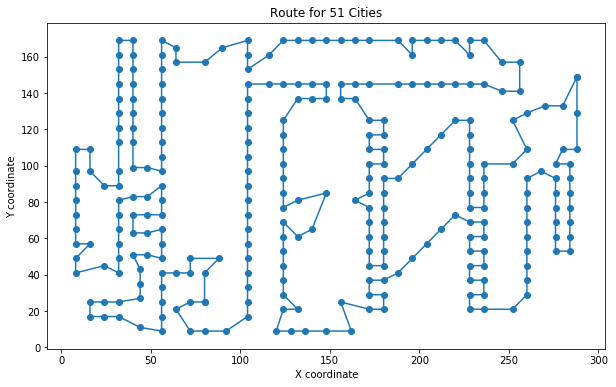

NameError: name 'res' is not defined

In [67]:
# optimal solution
opt_indices = []

# search for optimal solution in file
file = open('a280.opt.tour.txt', 'r') 
for line in file: 
    if RepresentsInt(line):
        opt_indices.append(int(line))
        
# optimal route
route = find_route(opt_indices[:len(opt_indices) - 1], city_list)
print('Optimal distance:', distance2(opt_indices[:len(opt_indices) - 1], city_list, d_m))
plot_route(route)

# found route
route_found = find_route(res[1], city_list)
print("Found distance:", res[2])
plot_route(route_found)

# plot of distance trough simulation
plt.plot(res[3])

# plot cumulative acceptance rate
plt.figure(3)
plt.plot(res[4])